In [58]:
# Bibliotheken importieren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Bibliothecken erfolgreich gelanden!")

Bibliothecken erfolgreich gelanden!


In [19]:
# Datensatz laden
df = pd.read_csv('../data/raw/OnlineRetail.csv', encoding='ISO-8859-1')
print(f"Datensatz geladen!")
print(f"\nDer DataFrame enthält {df.shape[0]:,} Zeilen und {df.shape[1]} Spalten")
print(f"\nErste 5 Zeilen:")
df.head()


Datensatz geladen!

Der DataFrame enthält 541,909 Zeilen und 8 Spalten

Erste 5 Zeilen:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [24]:
# Spalten Übersicht
print("Spalten im Datensatz:")
print("-"*50)
print(df.info())
print("\n"+"="*50)
print("\nStatistische Übersicht:")
df.describe()

Spalten im Datensatz:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


Statistische Übersicht:


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [35]:
# 1. Zeilen ohne CustomerID entfernen
print(f"Vor Bereinigung: {len(df):,} Zeilen")
df_clean = df[df['CustomerID'].notna()].copy()
print(f"Nach Entfernen fehlender CustomerIDs: {len(df_clean):,} Zeilen")

# 2. Nur positive Mengen
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
print(f"Nach Entfernung negativer Werte: {len(df_clean):,} Zeilen")

# 3.InvoiceDate in Datetime umwandeln
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# 4. Gesamtpreis berechnen
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']
print(f"\nDaten bereinigt!")
print(f"Final Daten {df_clean.shape}")
print(f"Anzahl einzigartiger Kunden: {df_clean['CustomerID'].nunique():,}")
df_clean.head()

Vor Bereinigung: 541,909 Zeilen
Nach Entfernen fehlender CustomerIDs: 406,829 Zeilen
Nach Entfernung negativer Werte: 397,884 Zeilen

Daten bereinigt!
Final Daten (397884, 9)
Anzahl einzigartiger Kunden: 4,338


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [43]:
# RFM-Analyse erstellen
print("="*50)
print("Feature Engineering: RFM-Analyse")
print("="*50)

# Referenzdatum berechnen (1 Tag nach dem letzten Kauf im Datensatz)
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Referenzdatum: {snapshot_date}")

# RFM pro Kunden berechnen
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x : (snapshot_date - x.max()).days,
    'InvoiceNo' : 'nunique',
    'TotalPrice' : 'sum'
}).reset_index()

# Spalten umbenennen
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Ergebnisse
print(f"\nRFM-Features erstellt für {len(rfm)} Kunden")
print("\nErste 10 Kunden")
print(rfm.head(10))
print("\nRFM Statistiken:")
print(rfm.describe())

# Prüfen auf problematische Werte
print(f"\nFehlende Werte:{rfm.isnull().sum().sum()}")
print(f"Negative Werte in Recency: {(rfm['Recency'] < 0).sum()}")
print(f"Null-Werte in Frequency: {(rfm['Frequency'] == 0).sum()}")
print(f"Null-Werte in Monetary:{(rfm['Monetary'] <= 0).sum()}")

Feature Engineering: RFM-Analyse
Referenzdatum: 2011-12-10 12:50:00

RFM-Features erstellt für 4338 Kunden

Erste 10 Kunden
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40
5     12352.0       36          8   2506.04
6     12353.0      204          1     89.00
7     12354.0      232          1   1079.40
8     12355.0      214          1    459.40
9     12356.0       23          3   2811.43

RFM Statistiken:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    1

Explorative Datenanalyse
--------------------------------------------------


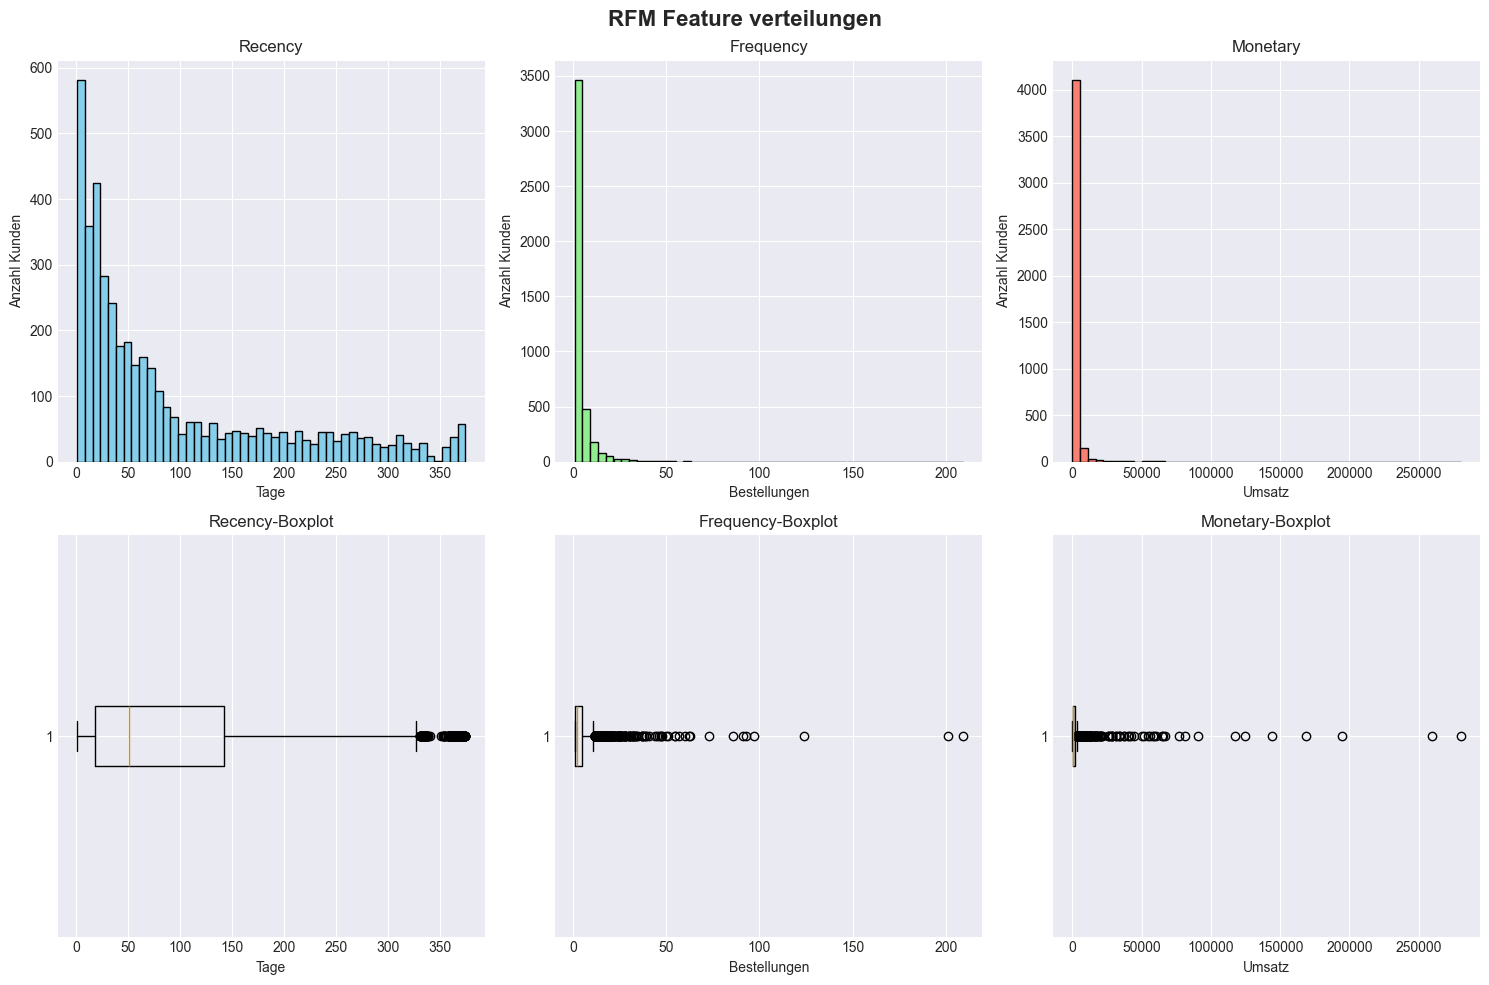


Ausreißer-Analyse:

Recency:
 - 95% der Kunden: <= 312 Tage
 - Maximum: 374 Tage

Frequency:
 - 95% der Kunden: <= 13 Bestellungen
 - Maximum: 209 Bestellungen

Monetary
 - 95% derKunden: <= 5841.84£
 - Maximum: 280206.02£

Erkenntnis: Die Daten sind stark rechtsschief!
 -> Wir brauchen Log-Transformation + Skalierung


In [55]:
# EDA Verteilungen visualisieren
print("Explorative Datenanalyse")
print("-"*50)
fig, axes = plt.subplots(2, 3, figsize=(15,10))
fig.suptitle('RFM Feature verteilungen', fontsize=16, fontweight='bold')
axes[0, 0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Recency')
axes[0, 0].set_xlabel('Tage')
axes[0, 0].set_ylabel('Anzahl Kunden')

axes[0, 1].hist(rfm['Frequency'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Frequency')
axes[0, 1].set_xlabel('Bestellungen')
axes[0, 1].set_ylabel('Anzahl Kunden')

axes[0, 2].hist(rfm['Monetary'], bins=50, color='salmon', edgecolor='black')
axes[0, 2].set_title('Monetary')
axes[0, 2].set_xlabel('Umsatz')
axes[0, 2].set_ylabel('Anzahl Kunden')

axes[1, 0].boxplot(rfm['Recency'], vert=False)
axes[1, 0].set_title('Recency-Boxplot')
axes[1, 0].set_xlabel('Tage')

axes[1, 1].boxplot(rfm['Frequency'], vert=False)
axes[1, 1].set_title('Frequency-Boxplot')
axes[1, 1].set_xlabel('Bestellungen')

axes[1, 2].boxplot(rfm['Monetary'], vert=False)
axes[1, 2].set_title('Monetary-Boxplot')
axes[1, 2].set_xlabel('Umsatz')

plt.tight_layout()
plt.show()

# statistische Kennzahlen für Ausreißer
print("\nAusreißer-Analyse:")
print("\nRecency:")
print(f" - 95% der Kunden: <= {rfm['Recency'].quantile(0.95):.0f} Tage")
print(f" - Maximum: {rfm['Recency'].max():.0f} Tage")

print("\nFrequency:")
print(f" - 95% der Kunden: <= {rfm['Frequency'].quantile(0.95):.0f} Bestellungen")
print(f" - Maximum: {rfm['Frequency'].max():.0f} Bestellungen")

print("\nMonetary")
print(f" - 95% derKunden: <= {rfm['Monetary'].quantile(0.95):.2f}£")
print(f" - Maximum: {rfm['Monetary'].max():.2f}£")

print("\nErkenntnis: Die Daten sind stark rechtsschief!")
print(" -> Wir brauchen Log-Transformation + Skalierung")

In [60]:
# Vorbereitung: Features extrahieren (ohne CustomerID)
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']].copy()
print("Schritt 1: Log-Transformation")
rfm_log = np.log1p(rfm_features)
print("Original vs. Log-transformiert:")
print("\nOriginal:")
print(rfm_features.describe())
print("\nNach Log-Transformation:")
print(rfm_log.describe())

# StandardScaler, mean = 0, std = 1
print("="*50)
print("Nach StandardScaler")
print("="*50)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Als DataFrame
rfm_scaled_df = pd.DataFrame(
    rfm_scaled,
    columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
)
print("Nach Skalierung (sollte ~0 mean, ~1 std haben):\n")
print(rfm_scaled_df.describe())

Schritt 1: Log-Transformation
Original vs. Log-transformiert:

Original:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266460
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000

Nach Log-Transformation:
           Recency    Frequency     Monetary
count  4338.000000  4338.000000  4338.000000
mean      3.830734     1.345582     6.593627
std       1.340261     0.683104     1.257578
min       0.693147     0.693147     1.558145
25%       2.944439     0.693147     5.731446
50%       3.951244     1.098612     6.515431
75%       4.962845     1.791759     7.416222
max       5.926926     5.347108    12.543284
Nach StandardScaler
Nach Skalierung (sollte ~0 mean, ~1 std haben):

    

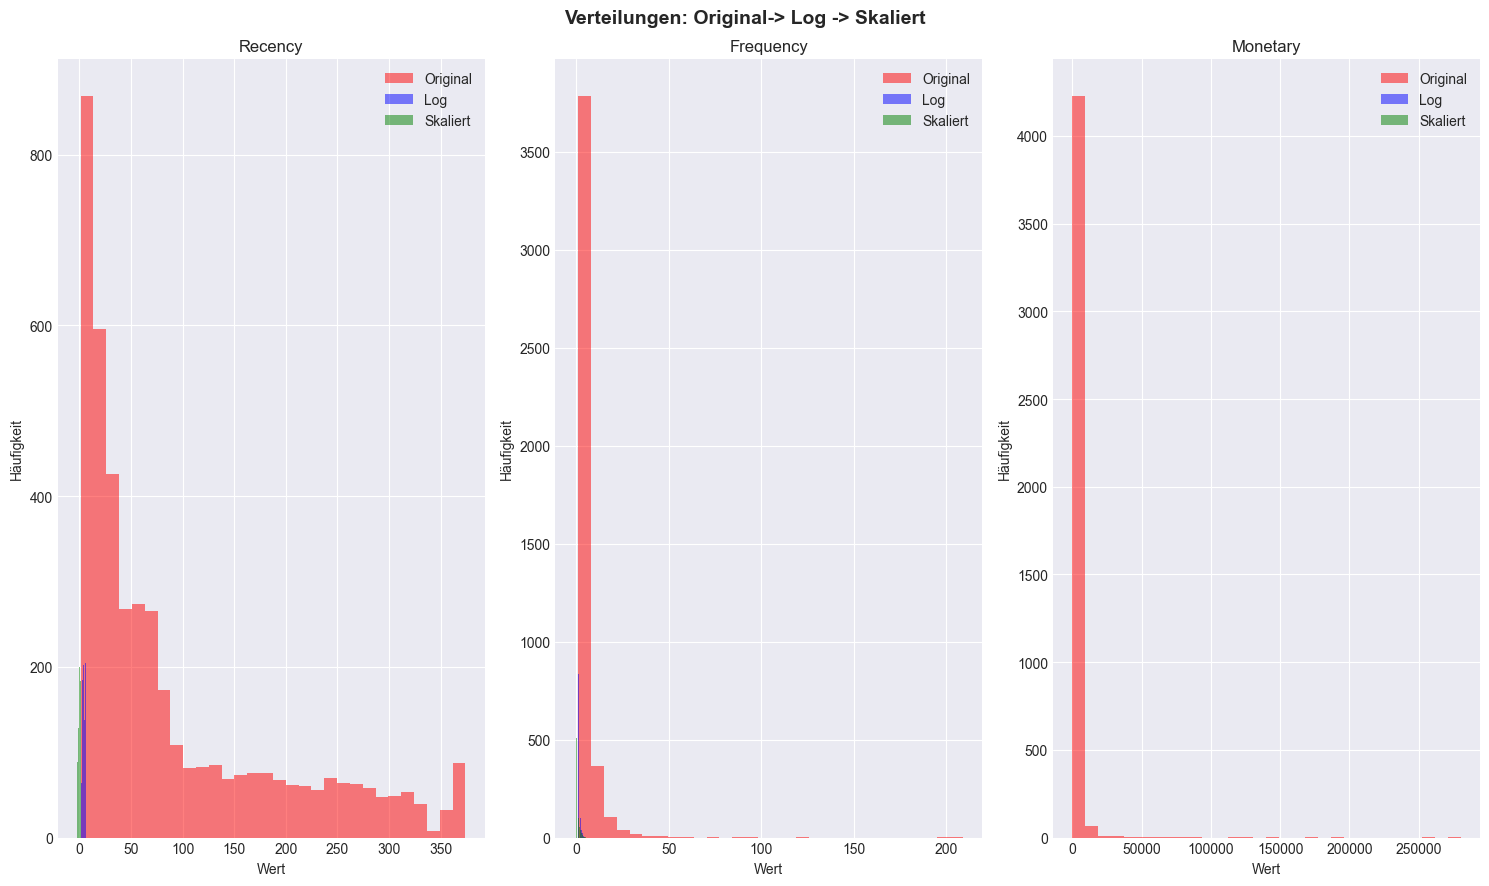

In [62]:
# Visualisierung: Vorher vs. Nachher
fig, axes = plt.subplots(1, 3, figsize=(15,9))
fig.suptitle('Verteilungen: Original-> Log -> Skaliert', fontsize=14, fontweight='bold')
features = ['Recency', 'Frequency', 'Monetary']
for idx, feature in enumerate(features):
    # Original
    axes[idx].hist(rfm_features[feature], bins=30, alpha=0.5, label='Original', color='red')
    # Log-transformiert
    axes[idx].hist(rfm_log[feature], bins=30, alpha=0.5, label='Log', color='blue')
    # Skaliert
    axes[idx].hist(rfm_scaled_df[f'{feature}_scaled'], bins=30, alpha=0.5, label='Skaliert', color='green')

    axes[idx].set_title(feature)
    axes[idx].legend()
    axes[idx].set_xlabel('Wert')
    axes[idx].set_ylabel('Häufigkeit')
plt.tight_layout()
plt.show()

In [63]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Ward-linkage berechnen
linkage_matrix = linkage(rfm_scaled_df, method='ward')
print("Linkage-Matrix erfolgreich berechnet!")
print(f"From der Linkage-Matrix: {linkage_matrix.shape}")
print(f"\nErste 5 Zeilen der Linkage-Matrix:")
print(linkage_matrix[:5])

Linkage-Matrix erfolgreich berechnet!
From der Linkage-Matrix: (4337, 4)

Erste 5 Zeilen der Linkage-Matrix:
[[3.46900000e+03 3.95800000e+03 8.26670927e-05 2.00000000e+00]
 [7.23000000e+02 4.24700000e+03 3.72912920e-04 2.00000000e+00]
 [2.63400000e+03 3.38400000e+03 4.18814291e-04 2.00000000e+00]
 [1.51700000e+03 2.06100000e+03 4.84305841e-04 2.00000000e+00]
 [1.18200000e+03 2.78500000e+03 7.79828699e-04 2.00000000e+00]]


Dendrogramm wurde gespeichert


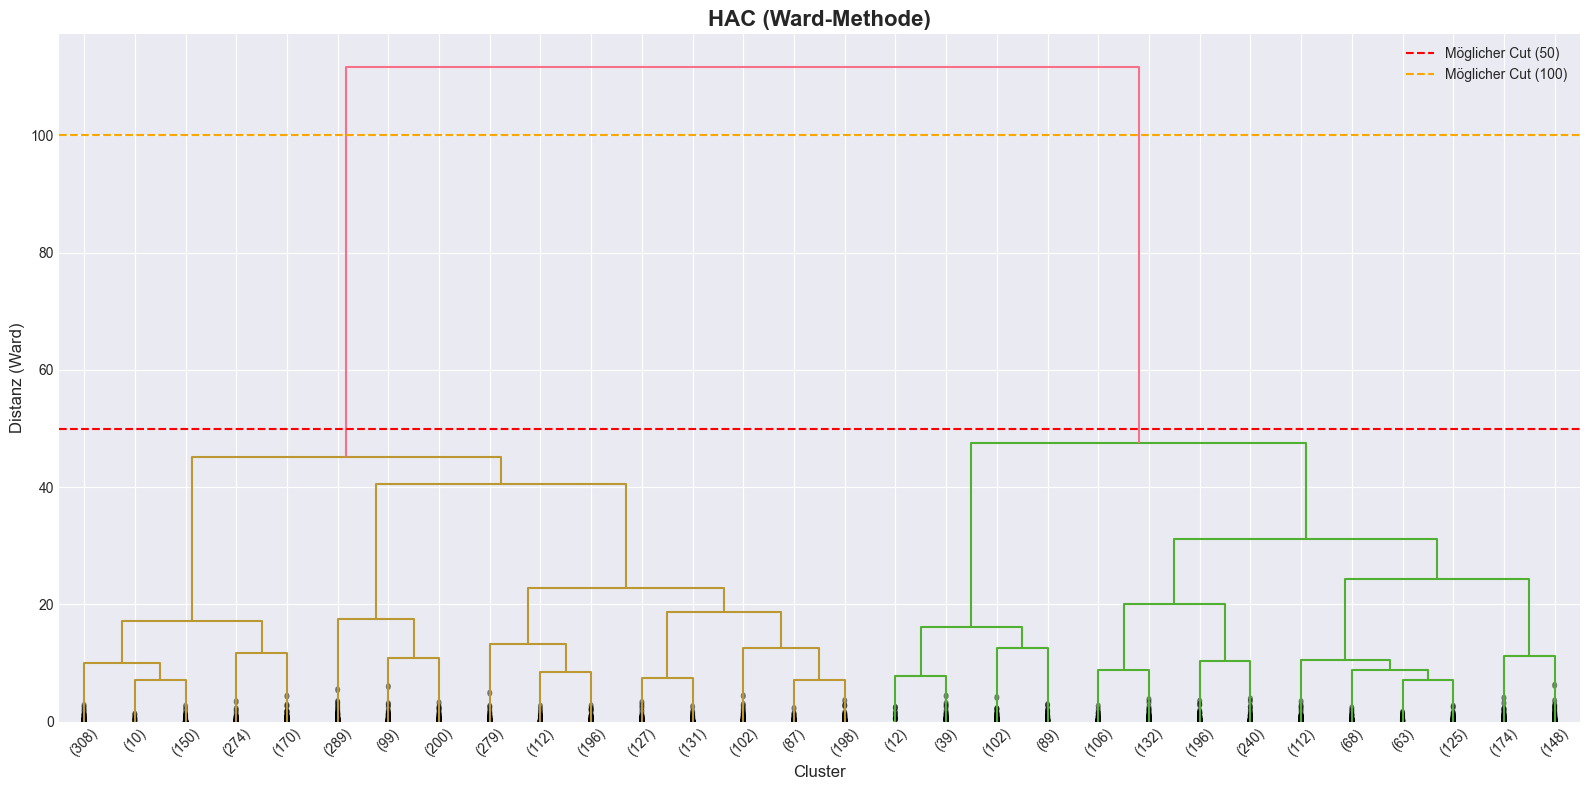

Dendrogramm wurde erstellt!


In [67]:
# Dendrogramm erstellen
plt.figure(figsize=(16, 8))
plt.title('HAC (Ward-Methode)', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Distanz (Ward)', fontsize=12)

dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=30,
    leaf_font_size=10,
    show_contracted=True
)
plt.axhline(y=50, color='r', linestyle='--', label='Möglicher Cut (50)')
plt.axhline(y=100, color='orange', linestyle='--', label='Möglicher Cut (100)')
plt.legend()
plt.tight_layout()
plt.savefig('../results/figures/dendogramm.png', dpi=300, bbox_inches='tight')
print("Dendrogramm wurde gespeichert")
plt.show()
print("Dendrogramm wurde erstellt!")

In [68]:
# Schneiden das Dendrogramm bei einer passenden Distanz
# Weisen jedem Kunden ein Cluster-label zu

n_clusters = 4
cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

rfm_scaled_df['Cluster'] = cluster_labels
print(f"Cluster-Labels erfolgreich erstellt!")
print(f"Anzahl der Cluster: {n_clusters}")
print(f"Verteilung der Cluster:")
print(rfm_scaled_df['Cluster'].value_counts().sort_index())

Cluster-Labels erfolgreich erstellt!
Anzahl der Cluster: 4
Verteilung der Cluster:
Cluster
1     912
2    1820
3     242
4    1364
Name: count, dtype: int64


In [70]:
# Original RFM-Daten mit Cluster-Labels kombinieren
rfm_with_clusters = rfm.copy()
rfm_with_clusters['Cluster'] = cluster_labels

# Mittelwerte pro Cluster berechnen (auf Original-Skala, Nicht log-transformiert)
cluster_summary = rfm_with_clusters.groupby('Cluster')[['Recency', 'Frequency', 'Monetary' ]].mean()
print("="*60)
print("Cluster-Charakteristiken (Mean werte)")
print("="*60)
print(cluster_summary.round(2))
print("\n")

# Cluster-Größen hinzufügen
cluster_sizes = rfm_with_clusters['Cluster'].value_counts().sort_index()
cluster_summary['Anzahl_Kunden'] = cluster_sizes

print("="*60)
print("Erweiterte Übersicht mit Cluster-Größen:")
print("="*60)
print(cluster_summary)

Cluster-Charakteristiken (Mean werte)
         Recency  Frequency  Monetary
Cluster                              
1         243.21       1.27    256.79
2          79.95       2.08    804.53
3          10.59      24.31  17458.93
4          23.13       5.64   2190.55


Erweiterte Übersicht mit Cluster-Größen:
            Recency  Frequency      Monetary  Anzahl_Kunden
Cluster                                                    
1        243.205044   1.269737    256.793739            912
2         79.948352   2.083516    804.527276           1820
3         10.586777  24.309917  17458.925620            242
4         23.131965   5.644428   2190.551592           1364


Plots gespeichert!


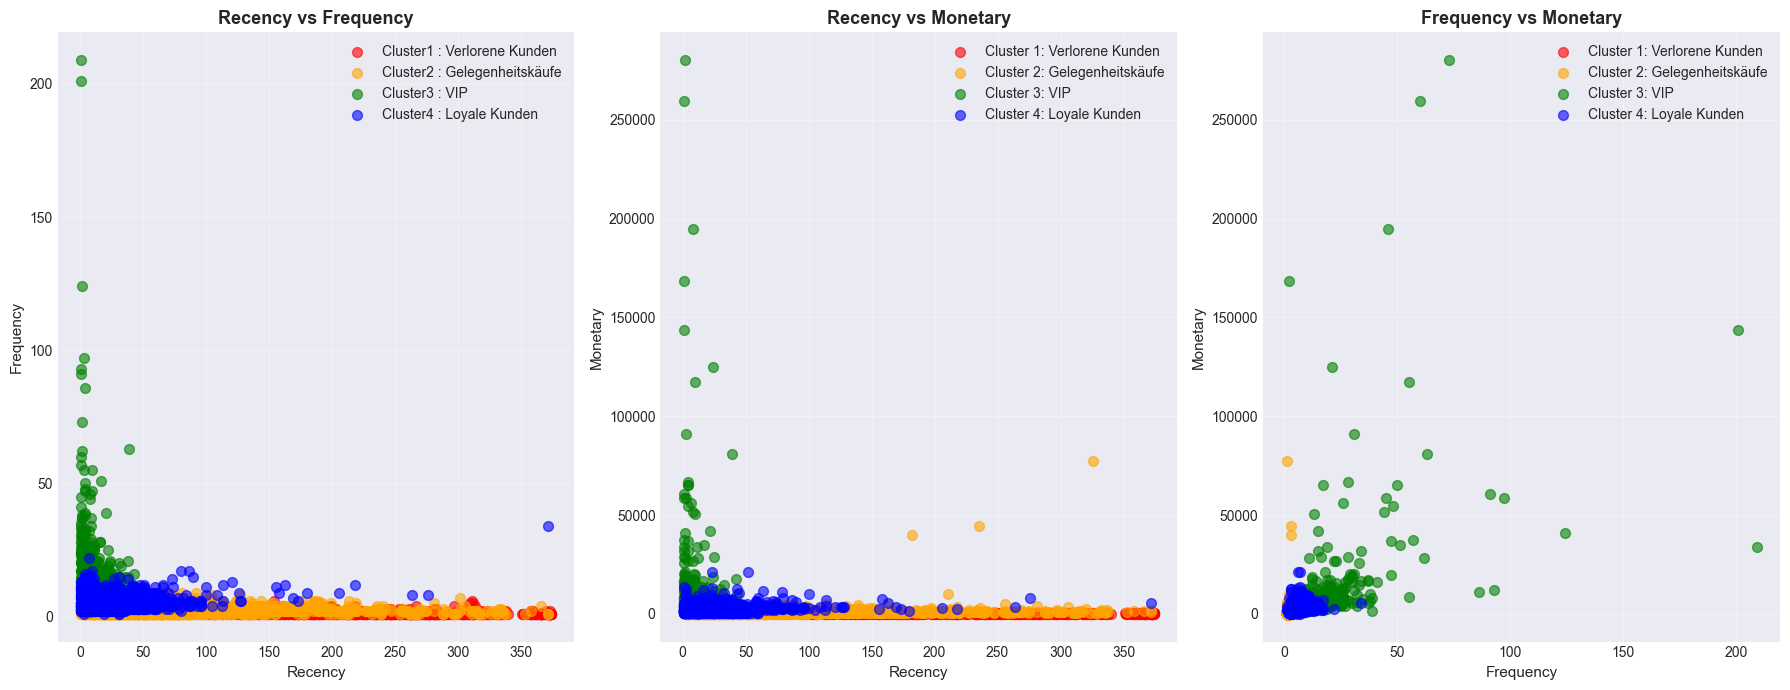

In [75]:
# Die Cluster visualisieren
# Farbe für die Cluster definieren
colors = {1: 'red', 2: 'orange', 3: 'green', 4: 'blue'}
cluster_names = {
    1: 'Verlorene Kunden',
    2: 'Gelegenheitskäufe',
    3: 'VIP',
    4: 'Loyale Kunden'
}
# Figure mit 3 Subplots erstellen
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

# Plot 1: Recency vs Frequency
for cluster in sorted(rfm_with_clusters['Cluster'].unique()):
    cluster_data = rfm_with_clusters[rfm_with_clusters['Cluster'] == cluster]
    axes[0].scatter(cluster_data['Recency'], cluster_data['Frequency'],
                   c=colors[cluster], label=f'Cluster{cluster} : {cluster_names[cluster]}',
                   alpha=0.6, s=50)
axes[0].set_xlabel('Recency', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Recency vs Frequency', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
# Plot 2: Recency vs Monetary
for cluster in sorted(rfm_with_clusters['Cluster'].unique()):
    cluster_data = rfm_with_clusters[rfm_with_clusters['Cluster'] == cluster]
    axes[1].scatter(cluster_data['Recency'], cluster_data['Monetary'],
                   c=colors[cluster], label=f'Cluster {cluster}: {cluster_names[cluster]}',
                   alpha=0.6, s=50)
axes[1].set_xlabel('Recency', fontsize=11)
axes[1].set_ylabel('Monetary', fontsize=11)
axes[1].set_title('Recency vs Monetary', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Plot 3: Frequency vs Monetary
for cluster in sorted(rfm_with_clusters['Cluster'].unique()):
    cluster_data = rfm_with_clusters[rfm_with_clusters['Cluster'] == cluster]
    axes[2].scatter(cluster_data['Frequency'], cluster_data['Monetary'],
                   c=colors[cluster], label=f'Cluster {cluster}: {cluster_names[cluster]}',
                   alpha=0.6, s=50)
axes[2].set_xlabel('Frequency', fontsize=11)
axes[2].set_ylabel('Monetary', fontsize=11)
axes[2].set_title('Frequency vs Monetary', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/cluster_scatterplots.png', dpi=300, bbox_inches='tight')
print("Plots gespeichert!")
plt.show()


✅ Histogramme gespeichert!


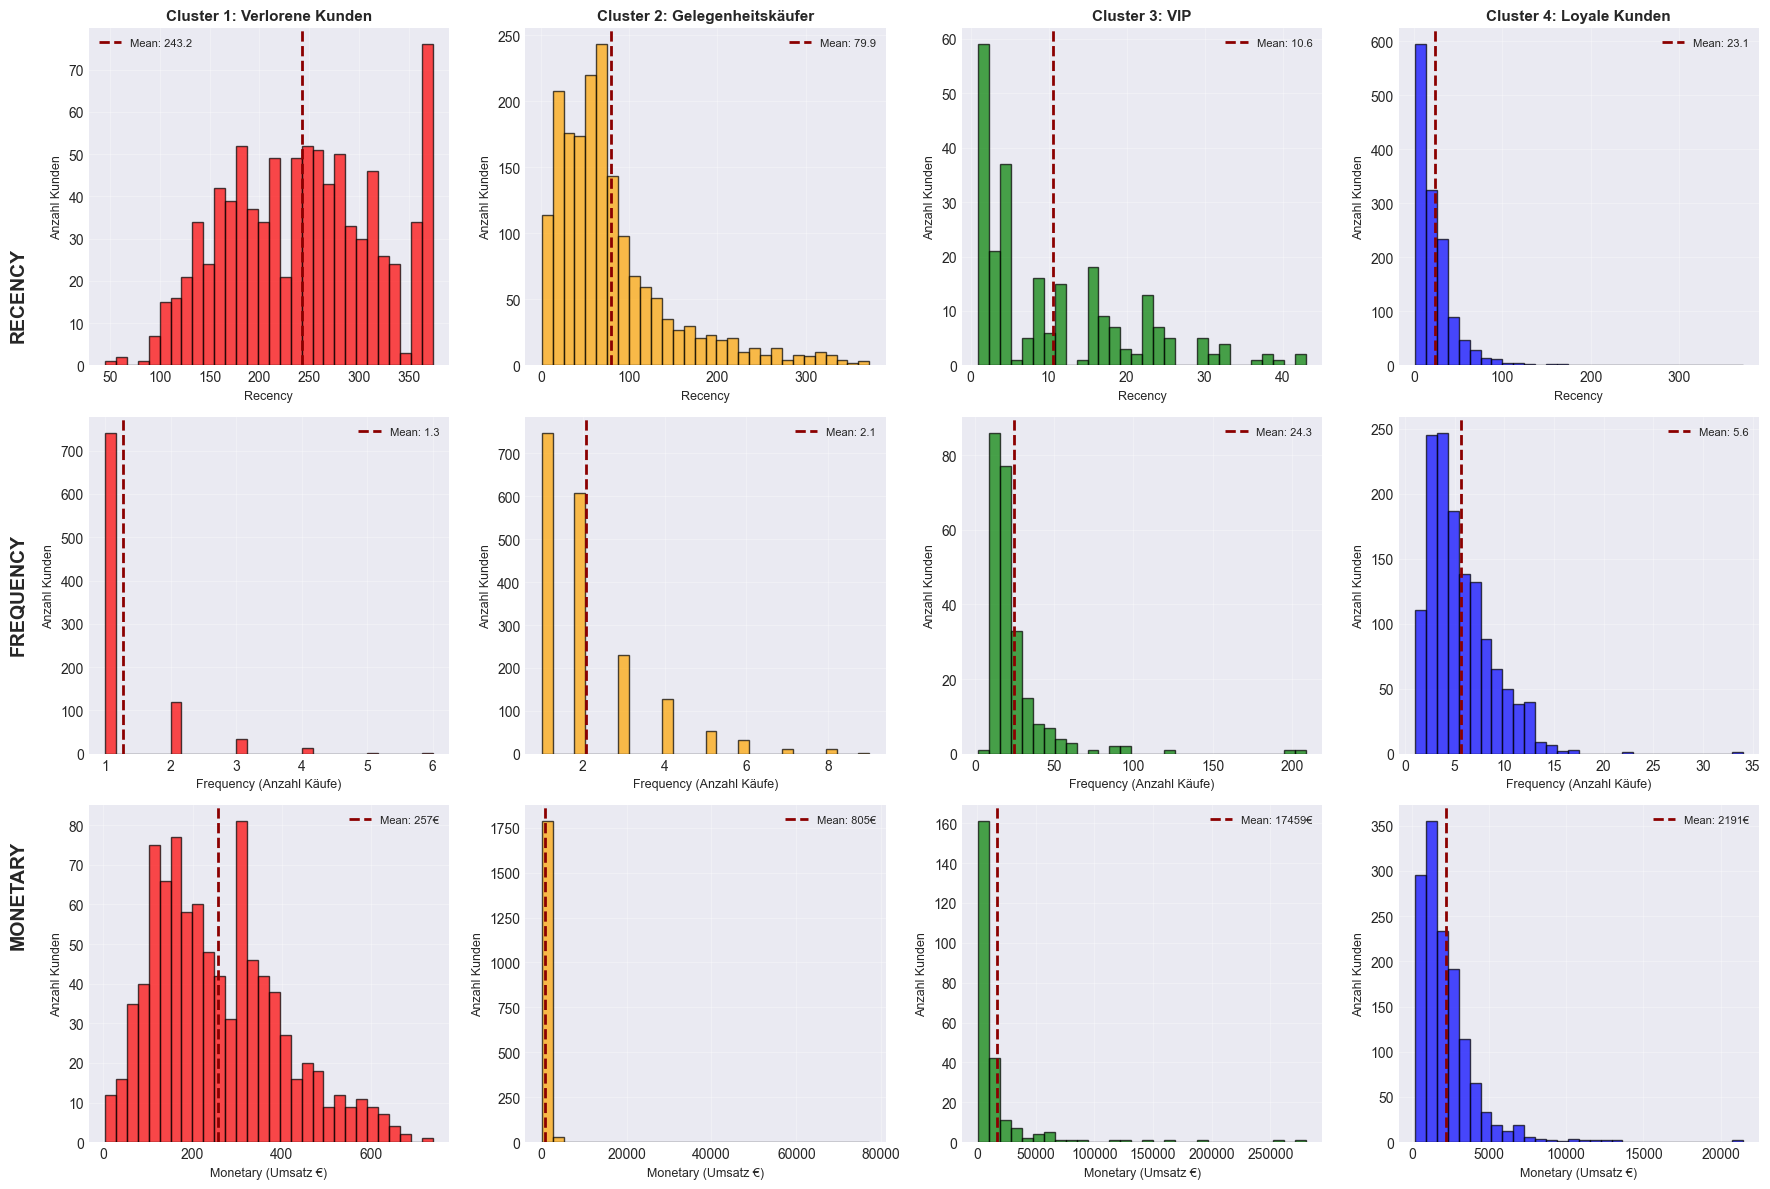

In [78]:
# Histogramme für Cluster vergleich
fig, axes = plt.subplots(3, 4, figsize=(18,12))
colors_list = ['red', 'orange', 'green', 'blue']
cluster_names = {
    1: 'Verlorene Kunden',
    2: 'Gelegenheitskäufer',
    3: 'VIP',
    4: 'Loyale Kunden'
}

# Für jeden Cluster ein Histogramm erstellen
for idx, cluster in enumerate([1, 2, 3, 4]):
    cluster_data = rfm_with_clusters[rfm_with_clusters['Cluster'] == cluster]

    # Recency Histogramm
    axes[0, idx].hist(cluster_data['Recency'], bins=30, color=colors_list[idx], alpha=0.7, edgecolor='black')
    axes[0, idx].set_title(f'Cluster {cluster}: {cluster_names[cluster]}', fontsize=11, fontweight='bold')
    axes[0, idx].set_xlabel('Recency', fontsize=9)
    axes[0, idx].set_ylabel('Anzahl Kunden', fontsize=9)
    axes[0, idx].axvline(cluster_data['Recency'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {cluster_data["Recency"].mean():.1f}')
    axes[0, idx].legend(fontsize=8)
    axes[0, idx].grid(alpha=0.3)

    # Frequency Histogram
    axes[1, idx].hist(cluster_data['Frequency'], bins=30, color=colors_list[idx], alpha=0.7, edgecolor='black')
    axes[1, idx].set_xlabel('Frequency (Anzahl Käufe)', fontsize=9)
    axes[1, idx].set_ylabel('Anzahl Kunden', fontsize=9)
    axes[1, idx].axvline(cluster_data['Frequency'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {cluster_data["Frequency"].mean():.1f}')
    axes[1, idx].legend(fontsize=8)
    axes[1, idx].grid(alpha=0.3)
    
    # Monetary Histogram
    axes[2, idx].hist(cluster_data['Monetary'], bins=30, color=colors_list[idx], alpha=0.7, edgecolor='black')
    axes[2, idx].set_xlabel('Monetary (Umsatz €)', fontsize=9)
    axes[2, idx].set_ylabel('Anzahl Kunden', fontsize=9)
    axes[2, idx].axvline(cluster_data['Monetary'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {cluster_data["Monetary"].mean():.0f}€')
    axes[2, idx].legend(fontsize=8)
    axes[2, idx].grid(alpha=0.3)

# Zeilen-Labels hinzufügen
fig.text(0.02, 0.75, 'RECENCY', va='center', rotation='vertical', fontsize=14, fontweight='bold')
fig.text(0.02, 0.50, 'FREQUENCY', va='center', rotation='vertical', fontsize=14, fontweight='bold')
fig.text(0.02, 0.25, 'MONETARY', va='center', rotation='vertical', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0.03, 0, 1, 1])
plt.savefig('../results/figures/cluster_histograms.png', dpi=300, bbox_inches='tight')
print("Histogramme gespeichert!")
plt.show()